# Single PMT angular acceptance

Here, we want to obtain single PMT angular acceptances with and without gelpads. The data should then be directly comparable with measurement results.

First, the imports:

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

As we might deal with a lot of data over multiple files, we define the histograms first and then fill them sequentially through a function:

In [2]:
# histogram edges
hist_phi_edges   = np.linspace(start=-np.pi, stop=np.pi,   num=200)
hist_theta_edges = np.linspace(start=0,      stop=np.pi/2, num=200)

# histograms
hist_no_gelpad_global = np.zeros((len(hist_phi_edges)-1, len(hist_theta_edges)-1))
hist_no_gelpad_detect = np.zeros((len(hist_phi_edges)-1, len(hist_theta_edges)-1))
hist_gelpad_global    = np.zeros((len(hist_phi_edges)-1, len(hist_theta_edges)-1))
hist_gelpad_detect    = np.zeros((len(hist_phi_edges)-1, len(hist_theta_edges)-1))

Then we define a function to fill the histograms. In accordance with the experiment, the photons are directed to the origin, being at the rotational center of the PMT at the height where the Photocathode meets the reflector. We thereby only need to look at their initial position for the angular acceptance:

In [3]:
def extract_data_to_histograms(datafile, gelpad = False):

    # reference global histograms
    global hist_no_gelpad_global
    global hist_no_gelpad_detect
    global hist_gelpad_global   
    global hist_gelpad_detect   

    # read in data
    df = pd.read_csv(datafile)

    # calculate position properties
    photons_pos_r      = np.sqrt(df['in_x']**2 + df['in_y']**2 + (df['in_z'])**2)
    photons_pos_theta  = np.pi/2 - np.arccos((df['in_z'])/photons_pos_r)
    photons_pos_phi    = np.arctan2(df['in_y'], df['in_x'])

    # get global histogram data
    if gelpad: hist_gelpad_global = hist_gelpad_global    + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_phi_edges, hist_theta_edges])[0]
    else:   hist_no_gelpad_global = hist_no_gelpad_global + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_phi_edges, hist_theta_edges])[0]

    # filter df by detected photons
    df = df.query("out_ProcessName == 'OpAbsorption' and out_VolumeName.str.contains('photocathode')")

    # get position properties on filtered dataset
    photons_pos_r      = np.sqrt(df['in_x']**2 + df['in_y']**2 + (df['in_z'])**2)
    photons_pos_theta  = np.pi/2 - np.arccos((df['in_z'])/photons_pos_r)
    photons_pos_phi    = np.arctan2(df['in_y'], df['in_x'])

    # get detected histogram data
    if gelpad: hist_gelpad_detect = hist_gelpad_detect    + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_phi_edges, hist_theta_edges])[0]
    else:   hist_no_gelpad_detect = hist_no_gelpad_detect + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_phi_edges, hist_theta_edges])[0]

Now we read in the datasets:

In [4]:
folder_path = '/home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data'

for filename in sorted(os.listdir(folder_path)):
    if filename.endswith(".csv") and filename.startswith("single_pmt"):
        
        gelpad = True
        if "no_gelpad" in filename: gelpad = False
        
        print(f"looking into {filename}")
        datafile = os.path.join(folder_path, filename)
        extract_data_to_histograms(datafile, gelpad)

looking into single_pmt_gelpad_0.csv
looking into single_pmt_gelpad_1.csv
looking into single_pmt_gelpad_10.csv
looking into single_pmt_gelpad_11.csv
looking into single_pmt_gelpad_12.csv
looking into single_pmt_gelpad_13.csv
looking into single_pmt_gelpad_14.csv
looking into single_pmt_gelpad_15.csv
looking into single_pmt_gelpad_16.csv
looking into single_pmt_gelpad_17.csv
looking into single_pmt_gelpad_18.csv
looking into single_pmt_gelpad_19.csv
looking into single_pmt_gelpad_2.csv
looking into single_pmt_gelpad_3.csv
looking into single_pmt_gelpad_4.csv
looking into single_pmt_gelpad_5.csv
looking into single_pmt_gelpad_6.csv
looking into single_pmt_gelpad_7.csv
looking into single_pmt_gelpad_8.csv
looking into single_pmt_gelpad_9.csv
looking into single_pmt_no_gelpad_0.csv
looking into single_pmt_no_gelpad_1.csv
looking into single_pmt_no_gelpad_10.csv
looking into single_pmt_no_gelpad_11.csv
looking into single_pmt_no_gelpad_12.csv
looking into single_pmt_no_gelpad_13.csv
lookin

We want to get a first feeling of the data and plot the 2D histograms: 

/tmp/ipykernel_3023/1306762685.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(hist_phi_edges, hist_theta_edges, hist.T)


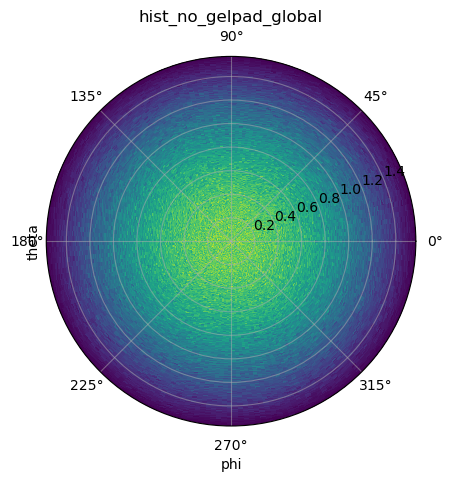

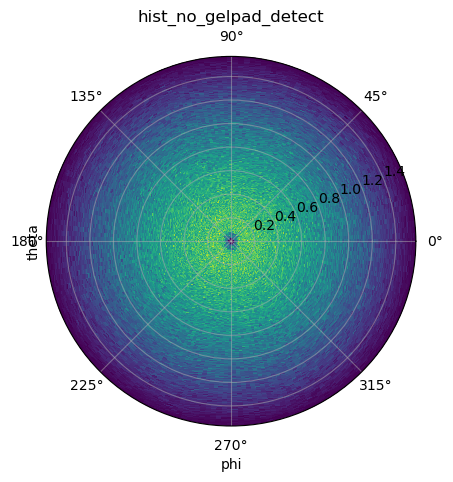

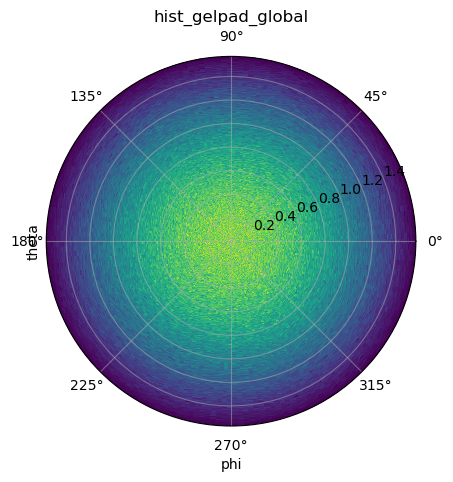

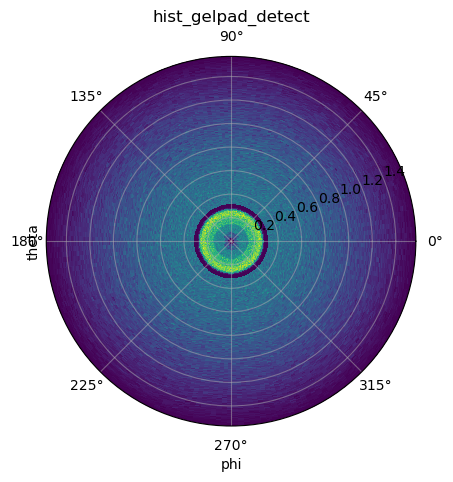

In [5]:
for hist in [hist_no_gelpad_global, hist_no_gelpad_detect, hist_gelpad_global, hist_gelpad_detect]:

    hist_name = [k for k, v in globals().items() if v is hist][0]

    ax = plt.subplot(111, projection='polar')
    ax.set_xlabel("phi")
    ax.set_ylabel("theta")
    #ax.set_theta_zero_location('N')
    #ax.set_theta_direction(-1)
    ax.pcolormesh(hist_phi_edges, hist_theta_edges, hist.T)
    ax.set_title(hist_name)
    ax.grid(alpha=0.5)
    plt.show();

now we want an estimate on the angular acceptance. We simply sum up everything along the phi axis and divide the detect histogram by the global histogram:

In [6]:
acceptance_no_gelpad = hist_no_gelpad_detect.sum(axis=0) / hist_no_gelpad_global.sum(axis=0)
acceptance_gelpad    = hist_gelpad_detect.sum(axis=0) / hist_gelpad_global.sum(axis=0)

lets plot this:

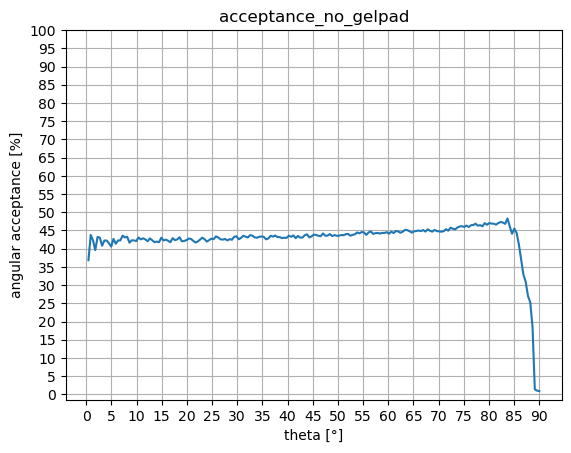

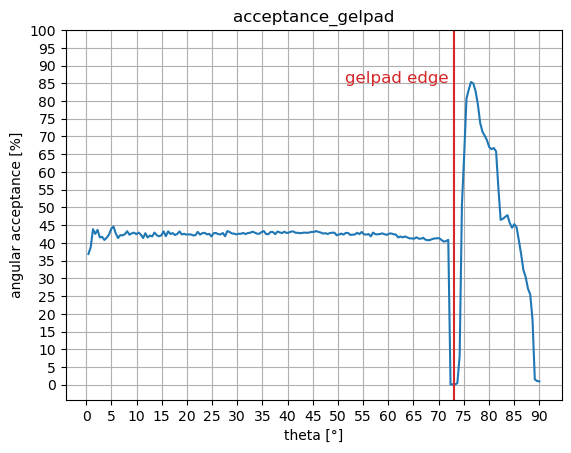

In [7]:
gelpad_edge  = 73
text_padding = 1
font_size    = 12

for hist in [acceptance_no_gelpad, acceptance_gelpad]:

    ax = plt.subplot()
    hist_name = [k for k, v in globals().items() if v is hist][1]
    ax.plot( 90 - np.rad2deg(hist_theta_edges[:-1]), hist * 100)
    ax.set_title(hist_name)
    ax.set_xlabel("theta [°]")
    ax.set_ylabel("angular acceptance [%]")

    if hist_name == "acceptance_gelpad":

        ax.text(gelpad_edge - text_padding, ax.get_ylim()[1] - text_padding, 'gelpad edge', fontsize=font_size, ha='right', va='top', color='tab:red')
        ax.axvline(gelpad_edge, c="tab:red")

    ax.set_xticks(np.arange(0, 95, 5))
    ax.set_yticks(np.arange(0, 105, 5))
    ax.grid()
    plt.show();